In [1]:
import pandas as pd
import os
from skimage.io import imread, imshow
from skimage.transform import rescale, resize
from skimage.feature.texture import greycoprops,greycomatrix



In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import matplotlib.pyplot as plt
from scipy.stats import skew,kurtosis,norm,moment


In [4]:

%matplotlib inline

<function matplotlib.pyplot.show>

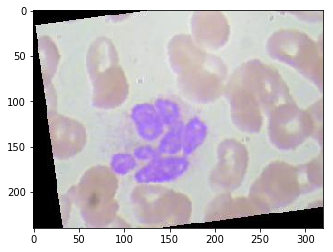

In [5]:
root_dir='C:\\Users\\RASHKE JAHAN'
data_dir=root_dir+'\\blood_cell'
training_img_dir=data_dir+'\\TRAIN'
test_img_dir=data_dir+'\\TEST'
img_array=cv2.imread(r'C:\Users\RASHKE JAHAN\blood_cell\TRAIN\EOSINOPHIL\_0_207.jpeg')
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
plt.show



In [8]:
# fixed-sizes for image
fixed_size = tuple((64, 64))


# no.of.trees for Random Forests
num_trees = 50

# bins for histogram
bins = 8


# seed for reproducing same results
seed = 9

In [9]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [10]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

In [1]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins,bins,bins], [0, 256, 0, 256, 0, 256])
    #hist  = cv2.calcHist([image], [0], None, [256], [0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()
    #return hist

In [12]:
labels = os.listdir(training_img_dir)
print(labels)


['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [13]:
%%time
image_list=[]
healthy_image_list=[]
unhealthy_image_list=[]
gray_image_list=[]
# loop over the training data sub-folders
for training_name in labels:
    # join the training data path and each species training folder
    label_path=os.path.join(training_img_dir,training_name)
    # get the current training label
    for img in os.listdir(label_path)[:4]:
        try:

        # read the image and resize it to a fixed-size
            image = cv2.imread(os.path.join(label_path,img))
            
            #image = cv2.resize(image, fixed_size)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # update the list of labels and feature vectors
            image_list.append(image)
            gray_image_list.append(gray_image)
        except Exception as e:
            pass

Wall time: 2.34 s


In [14]:
len(image_list)
image_list[0].shape

(240, 320, 3)

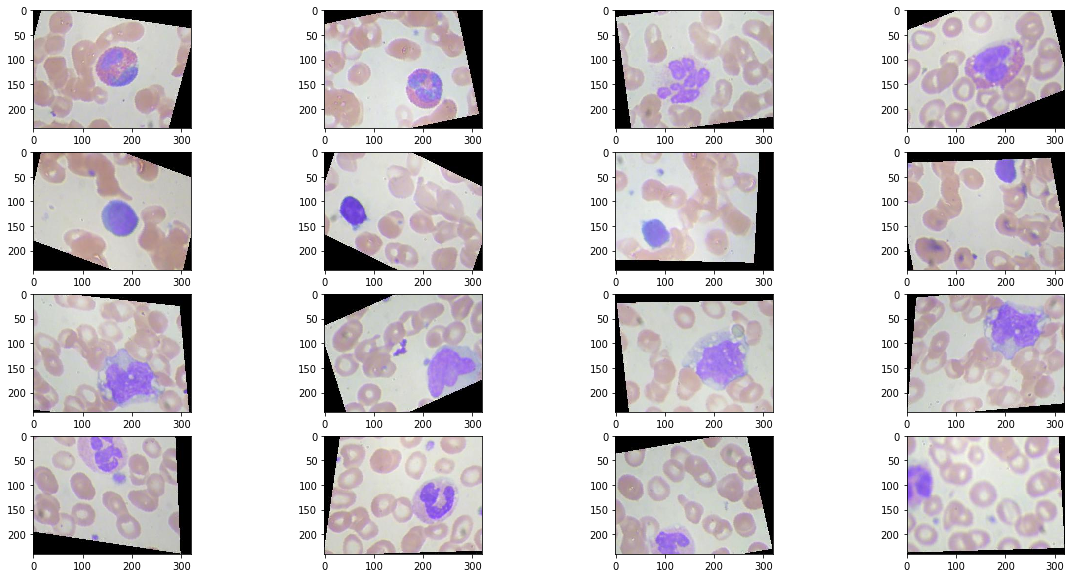

In [15]:
fig = plt.figure(figsize=(20,10))
for i,img in enumerate(image_list):
    
    plt.subplot(4, 4, i+1)
    plt.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
    
plt.show()


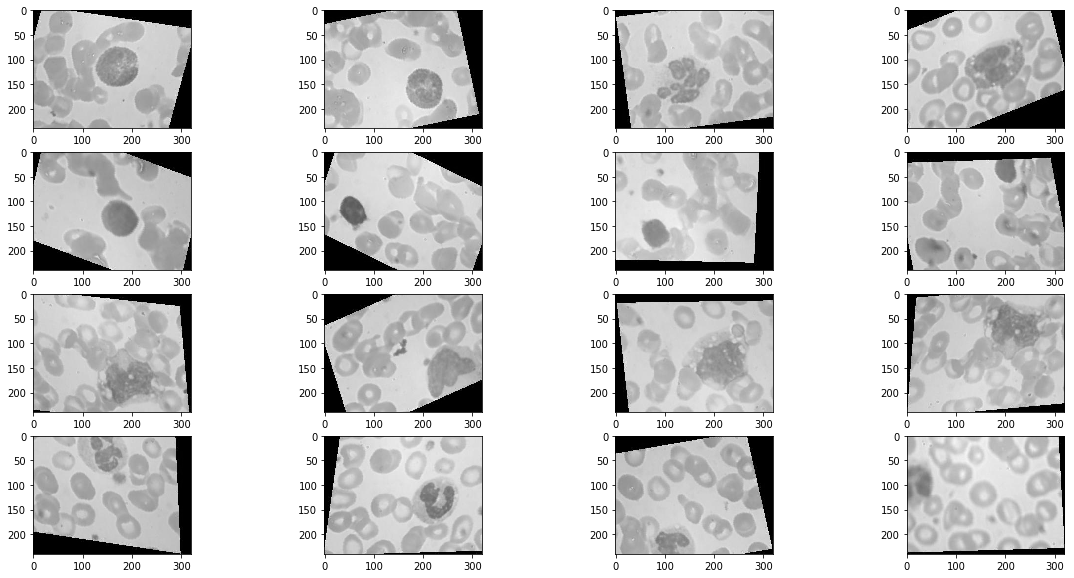

In [17]:
fig = plt.figure(figsize=(20,10))
for i,img in enumerate(gray_image_list):
    
    plt.subplot(4, 4, i+1)
    plt.imshow(cv2.cvtColor(gray_image_list[i], cv2.COLOR_BGR2RGB))
    
plt.show()

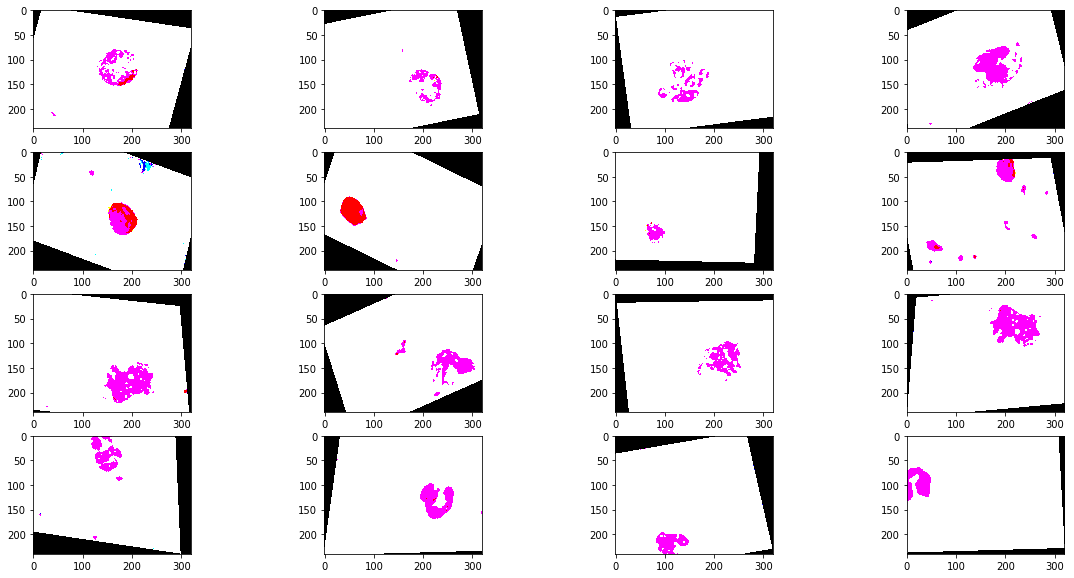

In [19]:
fig = plt.figure(figsize=(20,10))
for i,img in enumerate(image_list):
    
    plt.subplot(4, 4, i+1)
    
    ret1,th = cv2.threshold(image_list[i],127,255,cv2.THRESH_BINARY)
    plt.imshow(th)
    
plt.show()

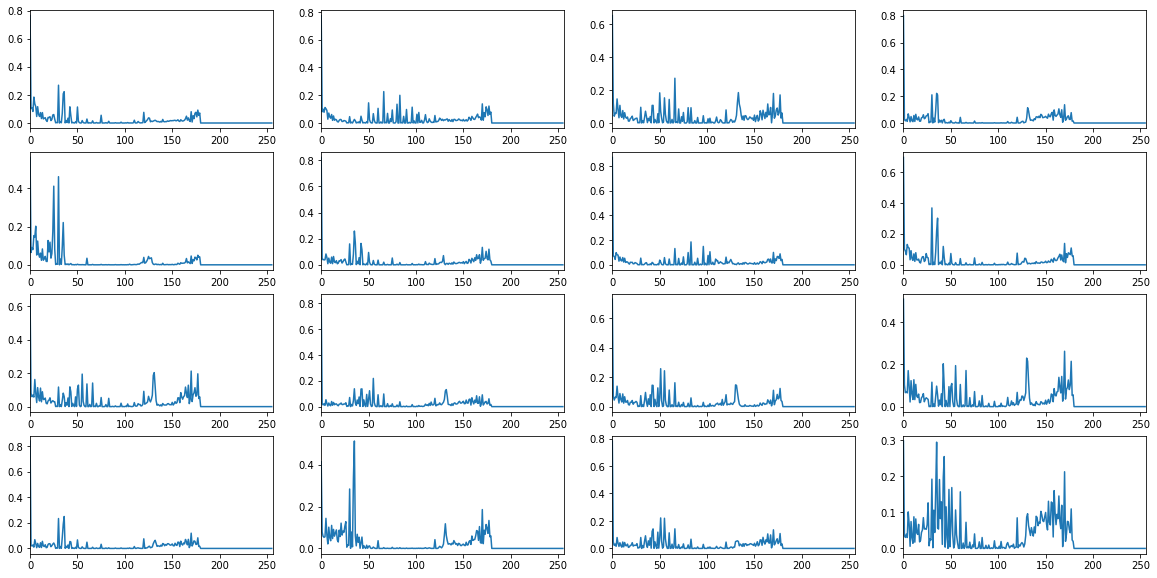

In [21]:
fig = plt.figure(figsize=(20,10))
for i,img in enumerate(image_list):
    fv_histogram  = fd_histogram(img)
    
    plt.subplot(4, 4, i+1)
    plt.plot(fv_histogram)
    plt.xlim([0,256])
    
plt.show()


## function for histogram statistical features

In [23]:
def stats(array):
    size=len(array)
    prob_dens=1/size
    skew=0
    var=0
    mean=np.mean(array)
    kurtosis=0
    for k in np.nditer(array):
        kurtosis= kurtosis+(((k-mean)**4)*prob_dens-3)
        skew=skew+((k-mean)**3)*prob_dens 
        var=var+((k-mean)**2)*prob_dens

    skew=skew*(var**-3/2)
    kurtosis= kurtosis*(var**-2)
    return mean,var,skew,kurtosis 

In [24]:
histogram_mean=[]
histogram_variance=[]
histogram_skew=[]
histogram_kurtosis=[]
for i,img in enumerate(image_list):
    hist= fd_histogram(img)
    mean,var,skew,kurtosis= stats(hist)
    histogram_mean.append(mean)
    histogram_variance.append(var)
    histogram_skew.append(skew)
    histogram_kurtosis.append(kurtosis)

len(histogram_mean)

16

In [25]:
print(histogram_mean)


[0.020393562, 0.023311254, 0.027506497, 0.020766109, 0.018524438, 0.019225214, 0.018727897, 0.021482978, 0.026994081, 0.020938186, 0.02342144, 0.02970425, 0.018257692, 0.025307946, 0.02307694, 0.034077656]


In [28]:
print(histogram_variance)

[0.0034903524153055564, 0.0033628356263616065, 0.0031496428375480164, 0.0034750193148594317, 0.0035630950838546529, 0.0035366409496901956, 0.0035555155656166303, 0.00344473185402448, 0.0031775692829765566, 0.0034678423661616579, 0.0033576864525765569, 0.0030239079889892795, 0.0035729069395873999, 0.0032657582456212574, 0.0033737044193500798, 0.0027449633398560504]


In [29]:
print(histogram_skew)

[20864.051246548708, 22990.460466405777, 17595.566821354816, 23416.013284744666, 14396.203822857355, 24079.089133547641, 27443.46440322767, 18328.213388250188, 16584.172591387316, 25878.120154219167, 20088.444705787315, 11806.321217911, 25097.914389727601, 13269.904434846259, 23510.414635630772, 7677.4039050149549]


In [30]:
print(histogram_kurtosis)

[-63040836.290019214, -67912423.805048496, -77417341.419292197, -63598363.715390883, -60493130.316030875, -61401410.616970062, -60751202.874689989, -64721693.822501719, -76062541.177817166, -63861859.439995848, -68120900.798957273, -83989294.976506919, -60161240.993064769, -72010022.207923114, -67475547.587717593, -101926728.50159445]


# function for histogram texture based features

In [26]:
def texture_feature(gray_img_list):
    x=[]
    y=[]
    z=[]
    p=[]
    q=[]
    for img in gray_image_list:
        g = greycomatrix(img,[1],[np.pi],  normed=True, symmetric=True)
        contrast = greycoprops(g, 'contrast')
        energy = greycoprops(g, 'energy')
        correlation = greycoprops(g, 'correlation')
        homogeneity = greycoprops(g, 'homogeneity')
        ASM = greycoprops(g, 'ASM')
        x.append(round(np.asscalar(contrast),3))
        y.append(round(np.asscalar(energy),3))
        z.append(round(np.asscalar(correlation),3))
        p.append(round(np.asscalar(homogeneity),3))
        q.append(round(np.asscalar(ASM),3))
    return x, y, z,p,q



In [27]:
x,y,z,p,q=texture_feature(gray_image_list)

data={"mean":histogram_mean,"variance":histogram_variance,"skewness":histogram_skew,"kurtosis":histogram_kurtosis,"contrast":x,"energy":y,"correlation":z,"homogeneity":p,"ASM":q}

In [28]:

features=pd.DataFrame(data)
features

,ASM,contrast,correlation,energy,homogeneity,kurtosis,mean,skewness,variance
0,0.013,134.089,0.984,0.113,0.573,-6.304084e+07,0.020394,20864.051247,0.003490
1,0.012,134.553,0.986,0.109,0.552,-6.791242e+07,0.023311,22990.460466,0.003363
2,0.005,132.166,0.981,0.074,0.503,-7.741734e+07,0.027506,17595.566821,0.003150
3,0.016,134.890,0.987,0.126,0.504,-6.359836e+07,0.020766,23416.013285,0.003475
4,0.014,117.235,0.986,0.116,0.633,-6.049313e+07,0.018524,14396.203823,0.003563
5,0.018,149.773,0.987,0.136,0.588,-6.140141e+07,0.019225,24079.089134,0.003537
6,0.025,126.981,0.990,0.157,0.618,-6.075120e+07,0.018728,27443.464403,0.003556
7,0.010,112.340,0.986,0.098,0.548,-6.472169e+07,0.021483,18328.213388,0.003445
8,0.006,121.068,0.981,0.074,0.491,-7.606254e+07,0.026994,16584.172591,0.003178
9,0.020,146.973,0.986,0.143,0.555,-6.386186e+07,0.020938,25878.120154,0.003468


In [29]:
# get the training labels


# sort the training labels
labels.sort()
print(len(labels))

# empty lists to hold feature vectors and labels
global_features = []
labels_code = []
data_list=[]




4


In [30]:
labels

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

# feature extraction 

In [35]:
%%time
# loop over the training data sub-folders
for name in labels:
    # join the training data path and each species training folder
    #dir = os.path.join(train_path, training_name)
    label_path=os.path.join(training_img_dir,name)
    # get the current training label
    current_label = name
    #print(name)
    # loop over the images in each sub-folder

    label_code=labels.index(name)
    
    for img in os.listdir(label_path):
        try:

        # read the image and resize it to a fixed-size
            image = cv2.imread(os.path.join(label_path,img))
            image = cv2.resize(image, fixed_size)
        #image = resize(image, (50, 50), mode='reflect')
            #print('resized')
        ####################################
        # Global Feature extraction
        ####################################
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)
            #print('features extracted')

        ###################################
        # Concatenate global features
        ###################################
            global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
            labels_code.append(current_label)
            global_features.append(global_feature)
            data_list.append([global_feature,label_code])
        except Exception as e:
            pass
    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: EOSINOPHIL
[STATUS] processed folder: LYMPHOCYTE
[STATUS] processed folder: MONOCYTE
[STATUS] processed folder: NEUTROPHIL
[STATUS] completed Global Feature Extraction...
Wall time: 6min 30s


In [36]:
len(data_list)

12855

In [37]:
test_labels = os.listdir(test_img_dir)

# sort the training labels
test_labels.sort()
print(len(test_labels))

# empty lists to hold feature vectors and labels
global_features_test = []
labels_test = []
data_list_test=[]
i, j = 0, 0
k = 0

4


In [38]:
%%time
# loop over the training data sub-folders
for name in test_labels:
    # join the training data path and each species training folder
    #dir = os.path.join(train_path, training_name)
    label_path=os.path.join(test_img_dir,name)
    # get the current training label
    current_label = name
    #print(name)
    # loop over the images in each sub-folder

    label_code=test_labels.index(name)
    
    for img in os.listdir(label_path):
        try:

        # read the image and resize it to a fixed-size
            image = cv2.imread(os.path.join(label_path,img))
            image = cv2.resize(image, fixed_size)
        #image = resize(image, (50, 50), mode='reflect')
            #print('resized')
        ####################################
        # Global Feature extraction
        ####################################
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)
            #print('features extracted')

        ###################################
        # Concatenate global features
        ###################################
            global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
            labels_code.append(current_label)
            global_features_test.append(global_feature)
            data_list_test.append([global_feature,label_code])
        except Exception as e:
            pass
    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: EOSINOPHIL
[STATUS] processed folder: LYMPHOCYTE
[STATUS] processed folder: MONOCYTE
[STATUS] processed folder: NEUTROPHIL
[STATUS] completed Global Feature Extraction...
Wall time: 1min 28s


In [41]:
len(data_list_test)

2487

In [42]:
from sklearn.externals import joblib

In [43]:
import random
random.shuffle(data_list)
type(data_list)

list

In [47]:
X=[]
y=[]

In [48]:
for feature, label in data_list:
    X.append(feature)
    y.append(label)


In [89]:
X=np.array(X)
y=np.array(y)

In [90]:
y.shape

(12855,)

In [91]:
data={'feature':X,'label':y}

In [111]:
len(data_list_test)

2487

In [112]:
random.shuffle(data_list_test)
type(data_list_test)

list

In [113]:
X_test=[]
y_test=[]

In [114]:
for feature, label in data_list_test:
    X_test.append(feature)
    y_test.append(label)

In [115]:
X_test=np.array(X_test)
y_test=np.array(y_test)

In [116]:
X_test.shape

(2487, 276)

In [117]:
test={'feature':X_test,'label':y_test}

In [118]:
joblib.dump(test,'blood_cell_test')

['blood_cell_test']

# run from here

In [4]:
from sklearn.externals import joblib

### dont run

In [119]:
joblib.dump(data,'bloodcell_dataset')

['bloodcell_dataset']

In [120]:
data_set=joblib.load('bloodcell_dataset')

In [137]:
X_train=data_set['feature']
y_train=data_set['label']

In [122]:
data_set_test=joblib.load('blood_cell_test')

In [132]:
X_test = data_set_test['feature']
y_test = data_set_test['label']

In [133]:
len(y_test)

2487

In [127]:
from sklearn.preprocessing import StandardScaler

In [128]:
scalify = StandardScaler()

In [138]:
%%time
scalify.fit(X)

Wall time: 115 ms


StandardScaler(copy=True, with_mean=True, with_std=True)

In [139]:
%%time
X_train_prepared=scalify.transform(X)

Wall time: 84.8 ms


In [107]:
%%time
scalify.fit(X_test)
X_test=scalify.transform(X_test)

Wall time: 200 ms


In [131]:
len(y_test)

2487

In [69]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [85]:
#X_train,X_test,y_train,y_test=train_test_split(X_train_prepared,y,test_size=.10, random_state=seed)

In [134]:
def clf_stastics(clf,test_set):
    y_pred=clf.predict(test_set)
    return[accuracy_score(y_test,y_pred),recall_score(y_test,y_pred),precision_score(y_test,y_pred)]

In [142]:
class_names = labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)



# Importing SGD classifier

In [135]:
from sklearn.linear_model import SGDClassifier

In [140]:
%%time
sgd_clf = SGDClassifier( random_state=42,max_iter=1000, tol=1e-3, loss="log", penalty="l2",n_jobs=-1,alpha=0.001)
sgd_clf.fit(X_train_prepared, y_train)

Wall time: 1.36 s


prediction of 30 samples of test data set

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 3 2 0 3 3 2 0 2 0 2 1 2 0 1 2 2 2 2 3 1 0 3 2 0 3 2 1 3 0]


Confusion matrix, without normalization
[[  0 623   0   0]
 [  0 620   0   0]
 [  0 620   0   0]
 [  0 624   0   0]]
Normalized confusion matrix
[[ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]]


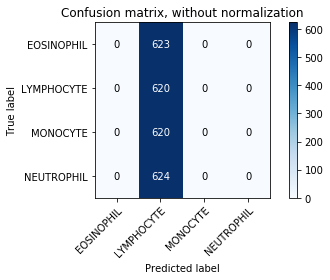

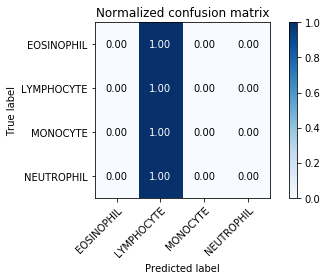

accuracy, recall and precision


ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [143]:
from sklearn.metrics import accuracy_score
y_pred_sgd = sgd_clf.predict(X_test)
#predict 30 samples of test data set
print('prediction of 30 samples of test data set\n')
print(y_pred_sgd[:30])
print(y_test[:30])
print('\n')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_sgd, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_sgd, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#print accuracy, recall and precision
print('accuracy, recall and precision')
sgd_stats=clf_stastics(sgd_clf,X_test)
print(sgd_stats)

In [150]:
y_pred=sgd_clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.249296340973


# logistic regression

In [144]:
from sklearn.linear_model import LogisticRegression
lgr_clf=LogisticRegression(solver='lbfgs', multi_class='multinomial',random_state=9,C=100)

In [145]:
%%time
lgr_clf.fit(X_train,y_train)

Wall time: 2.2 s


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=9, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [151]:
%%time
from sklearn.metrics import accuracy_score
y_pred_lgr=lgr_clf.predict(X_test)
print(y_pred_lgr[:30])
print(y_test[:30])


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 3 2 0 3 3 2 0 2 0 2 1 2 0 1 2 2 2 2 3 1 0 3 2 0 3 2 1 3 0]
Wall time: 5.44 ms


In [152]:
y_pred=lgr_clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.250502613591


prediction of 30 samples of test data set

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 3 2 0 3 3 2 0 2 0 2 1 2 0 1 2 2 2 2 3 1 0 3 2 0 3 2 1 3 0]


Confusion matrix, without normalization
[[623   0   0   0]
 [620   0   0   0]
 [620   0   0   0]
 [624   0   0   0]]
Normalized confusion matrix
[[ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]]


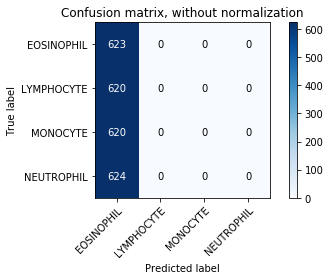

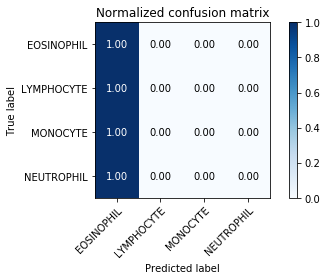

accuracy, recall and precision


ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [147]:

from sklearn.metrics import accuracy_score
y_pred_lgr = lgr_clf.predict(X_test)
#predict 30 samples of test data set
print('prediction of 30 samples of test data set\n')
print(y_pred_lgr[:30])
print(y_test[:30])
print('\n')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_lgr, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_lgr, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#print accuracy, recall and precision
print('accuracy, recall and precision')
lgr_stats=clf_stastics(lgr_clf,X_test)
print(lgr_stats)


# decision tree

In [153]:
from sklearn.tree import DecisionTreeClassifier
dtc_clf=DecisionTreeClassifier(random_state=9)

In [154]:
dtc_clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=9,
            splitter='best')

In [155]:
%%time
from sklearn.metrics import accuracy_score
y_pred_dtc=dtc_clf.predict(X_test)
print(y_pred_dtc[:30])
print(y_test[:30])
print(accuracy_score(y_test,y_pred_dtc))

[0 0 2 0 3 0 2 0 0 0 3 1 1 0 0 2 3 1 1 0 1 3 3 0 1 0 1 1 3 3]
[0 3 2 0 3 3 2 0 2 0 2 1 2 0 1 2 2 2 2 3 1 0 3 2 0 3 2 1 3 0]
0.48974668275
Wall time: 13.2 ms


prediction of 30 samples of test data set

[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 0]
[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1]


Confusion matrix, without normalization
[[1246   88]
 [  93 1329]]
Normalized confusion matrix
[[ 0.93  0.07]
 [ 0.07  0.93]]


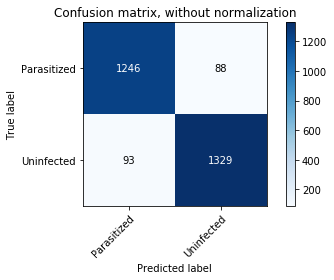

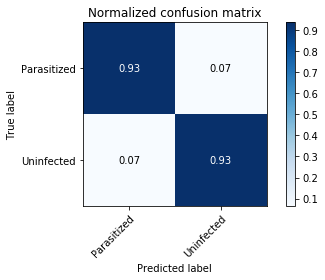

accuracy, recall and precision
[0.93432510885341069, 0.93459915611814348, 0.9378969654199012]


In [98]:
from sklearn.metrics import accuracy_score
y_pred_dtc = dtc_clf.predict(X_test)
#predict 30 samples of test data set
print('prediction of 30 samples of test data set\n')
print(y_pred_dtc[:30])
print(y_test[:30])
print('\n')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_dtc, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_dtc, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#print accuracy, recall and precision
print('accuracy, recall and precision')
dtc_stats=clf_stastics(dtc_clf,X_test)
print(dtc_stats)


In [156]:
from sklearn. ensemble import AdaBoostClassifier, VotingClassifier


In [157]:
 evc_clf = VotingClassifier( estimators= [('lgr_clf',lgr_clf),('dtc_clf',dtc_clf),('sgd_clf',sgd_clf)],voting='soft')

In [158]:
evc_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lgr_clf', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=9, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('dtc_cl...y='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [159]:
from sklearn.metrics import accuracy_score
y_pred_evc=evc_clf.predict(X_test)
print(y_pred_evc[30:60])
print(y_test[30:60])
print(accuracy_score(y_test,y_pred_evc))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 2 0 3 3 0 3 3 1 0 3 2 1 3 0 3 3 1 2 1 0 0 1 0 1 2 1 0 3 2]
0.250502613591


C:\Users\RASHKE JAHAN\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


prediction of 30 samples of test data set

[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0]
[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1]


Confusion matrix, without normalization
[[1245   89]
 [  58 1364]]
Normalized confusion matrix
[[ 0.93  0.07]
 [ 0.04  0.96]]


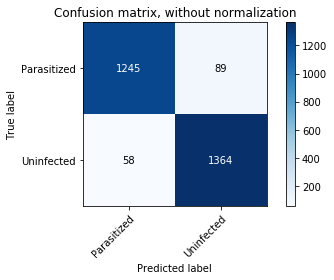

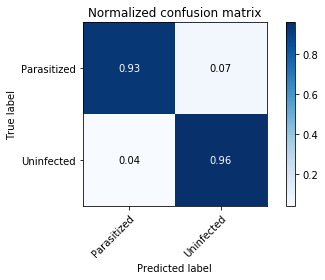

accuracy, recall and precision
[0.94666182873730043, 0.95921237693389594, 0.93874741913282866]


In [110]:
from sklearn.metrics import accuracy_score
y_pred_evc = evc_clf.predict(X_test)
#predict 30 samples of test data set
print('prediction of 30 samples of test data set\n')
print(y_pred_evc[:30])
print(y_test[:30])
print('\n')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_evc, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_evc, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#print accuracy, recall and precision
print('accuracy, recall and precision')
evc_stats=clf_stastics(evc_clf,X_test)
print(evc_stats)


In [107]:
%%time
adb_clf=AdaBoostClassifier(random_state=9,base_estimator=evc_clf,n_estimators=100)
adb_clf.fit(X_train,y_train)

Wall time: 47.4 s


prediction of 30 samples of test data set

[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0]
[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1]


Confusion matrix, without normalization
[[1257   77]
 [  55 1367]]
Normalized confusion matrix
[[ 0.94  0.06]
 [ 0.04  0.96]]


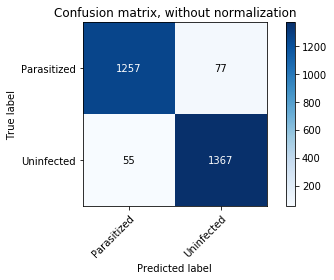

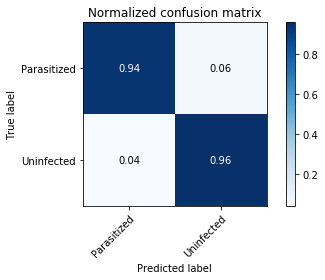

accuracy, recall and precision
[0.95210449927431062, 0.96132208157524612, 0.94667590027700832]


In [111]:
from sklearn.metrics import accuracy_score
y_pred_adb = adb_clf.predict(X_test)
#predict 30 samples of test data set
print('prediction of 30 samples of test data set\n')
print(y_pred_lgr[:30])
print(y_test[:30])
print('\n')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_adb, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_adb, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#print accuracy, recall and precision
print('accuracy, recall and precision')
adb_stats=clf_stastics(adb_clf,X_test)
print(adb_stats)


In [109]:
from sklearn.metrics import accuracy_score
y_pred_adb=adb_clf.predict(X_test)
print(y_pred_adb[30:60])
print(y_test[30:60])
print(accuracy_score(y_test,y_pred_adb))


[0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0]
[0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0]
0.952104499274


Automatically created module for IPython interactive environment


ValueError: X has 2 features per sample; expecting 532

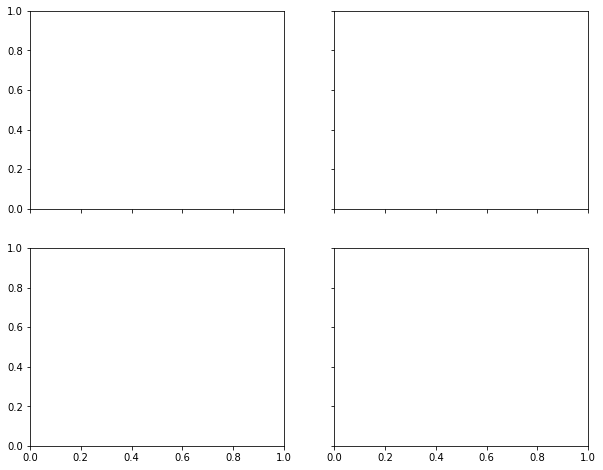

In [193]:
print(__doc__)

from itertools import product

# Plotting decision regions
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [sgd_clf, lgr_clf, dtc_clf, evc_clf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X_test[:, 0], X_test[:, 1], c=y_train,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [198]:
stats=pd.DataFrame({"sgd":sgd_stats,"lgr":lgr_stats,"dtc":dtc_stats,"evc":evc_stats,"adb":adb_stats},index=["accuracy","recall","precision"])
stats

NameError: name 'sgd_stats' is not defined

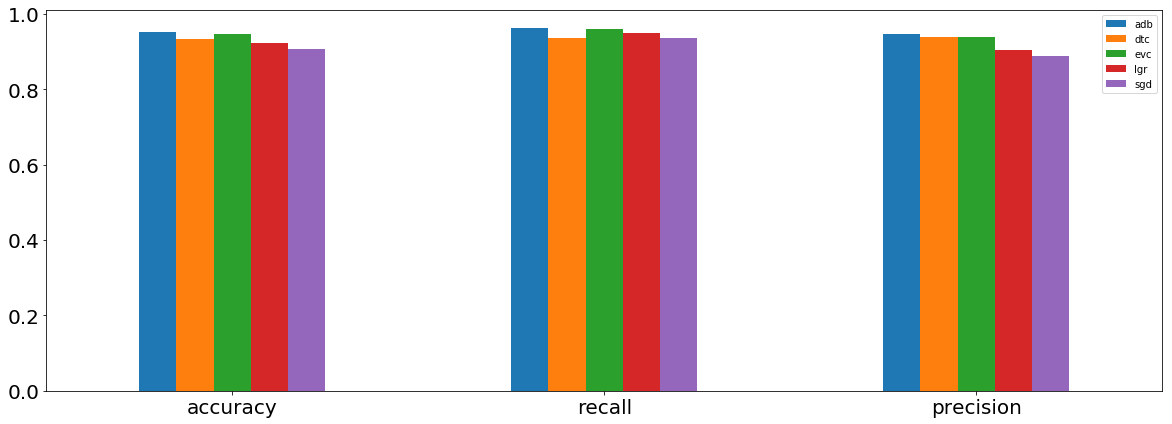

In [121]:

stats.plot.bar(rot=0,figsize=(20,7),fontsize =20)

  